In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 13:24:12.322437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 13:24:14.618271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## ResNet50

In [5]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(2048, activation='relu'))
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-13 13:24:32.473887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 13:24:32.543357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 13:24:32.543749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                         

In [7]:
import time
# Record the start time of training
start_time = time.time()

In [8]:
# Train the model
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='resnet50_model_32batchsize.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]


#Training
resnet_history = resnet_model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // 32,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // 32)

Epoch 1/10


2024-04-13 13:24:55.706871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 13:24:57.889931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 13:24:59.241586: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb280152910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 13:24:59.241637: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 13:24:59.290289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 13:24:59.604560: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

52/52 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.4181
Epoch 1: val_loss improved from inf to 3.87685, saving model to resnet50_model_32batchsize.h5
52/52 [==============================] - 62s 1s/step - loss: 1.4843 - accuracy: 0.4181 - val_loss: 3.8769 - val_accuracy: 0.1683
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 1.2016 - accuracy: 0.5328
Epoch 2: val_loss improved from 3.87685 to 3.51749, saving model to resnet50_model_32batchsize.h5
52/52 [==============================] - 51s 977ms/step - loss: 1.2016 - accuracy: 0.5328 - val_loss: 3.5175 - val_accuracy: 0.1899
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 1.1175 - accuracy: 0.5819
Epoch 3: val_loss improved from 3.51749 to 2.10775, saving model to resnet50_model_32batchsize.h5
52/52 [==============================] - 50s 969ms/step - loss: 1.1175 - accuracy: 0.5819 - val_loss: 2.1078 - val_accuracy: 0.2764
Epoch 4/10
52/52 [============================

In [9]:
# Record the training end time
end_time = time.time()

In [10]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 548.1308081150055 seconds


In [11]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.484255,0.418083,3.876851,0.168269
1,1.201584,0.532767,3.517492,0.189904
2,1.117508,0.581917,2.107754,0.276442
3,1.030331,0.616505,1.475988,0.408654
4,0.995432,0.608617,1.437288,0.444712
5,0.957535,0.643811,1.384166,0.475962
6,0.903737,0.656553,1.113662,0.625000
7,0.924315,0.657160,1.050265,0.622596
8,0.861900,0.677184,1.024734,0.632212
9,0.877736,0.674757,0.997928,0.591346


In [12]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50_DA_32batchsize.pkl')
history_CNN1 = joblib.load('history_ResNet50_DA_32batchsize.pkl')

In [13]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

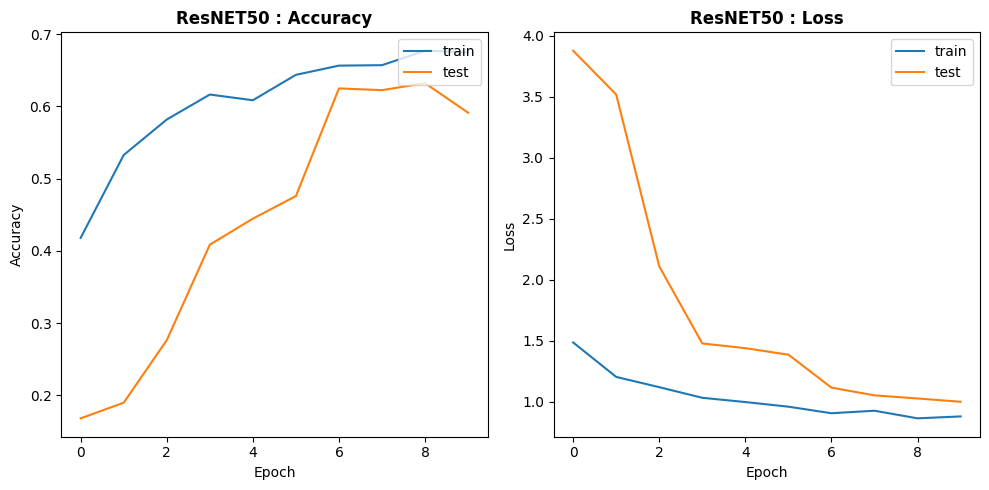

In [15]:
plot_performance(model_name='ResNET50',
                acc=history_CNN1['accuracy'], 
                 val_acc=history_CNN1['val_accuracy'],
                 loss=history_CNN1['loss'], 
                 val_loss=history_CNN1['val_loss'])

In [16]:
# Load the best saved model
from keras.models import load_model

model_1 = load_model('resnet50_model_32batchsize.h5')
score = model_1.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_1.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 12s 790ms/step - loss: 1.0465 - accuracy: 0.6095

Val loss: 1.0464526414871216
Val accuracy: 0.6095238327980042
17/17 [==============================] - 13s 758ms/step - loss: 0.8912 - accuracy: 0.6648

Test loss: 0.8912186622619629
Test accuracy: 0.6647727489471436


In [17]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 13s 709ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.70      0.89      0.78        88
           brown_spot       0.54      0.50      0.52        88
              healthy       0.74      0.70      0.72        88
           leaf_blast       0.49      0.35      0.41        88
           leaf_scald       0.70      0.78      0.74        88
    narrow_brown_spot       0.67      0.68      0.67        88

             accuracy                           0.65       528
            macro avg       0.64      0.65      0.64       528
         weighted avg       0.64      0.65      0.64       528



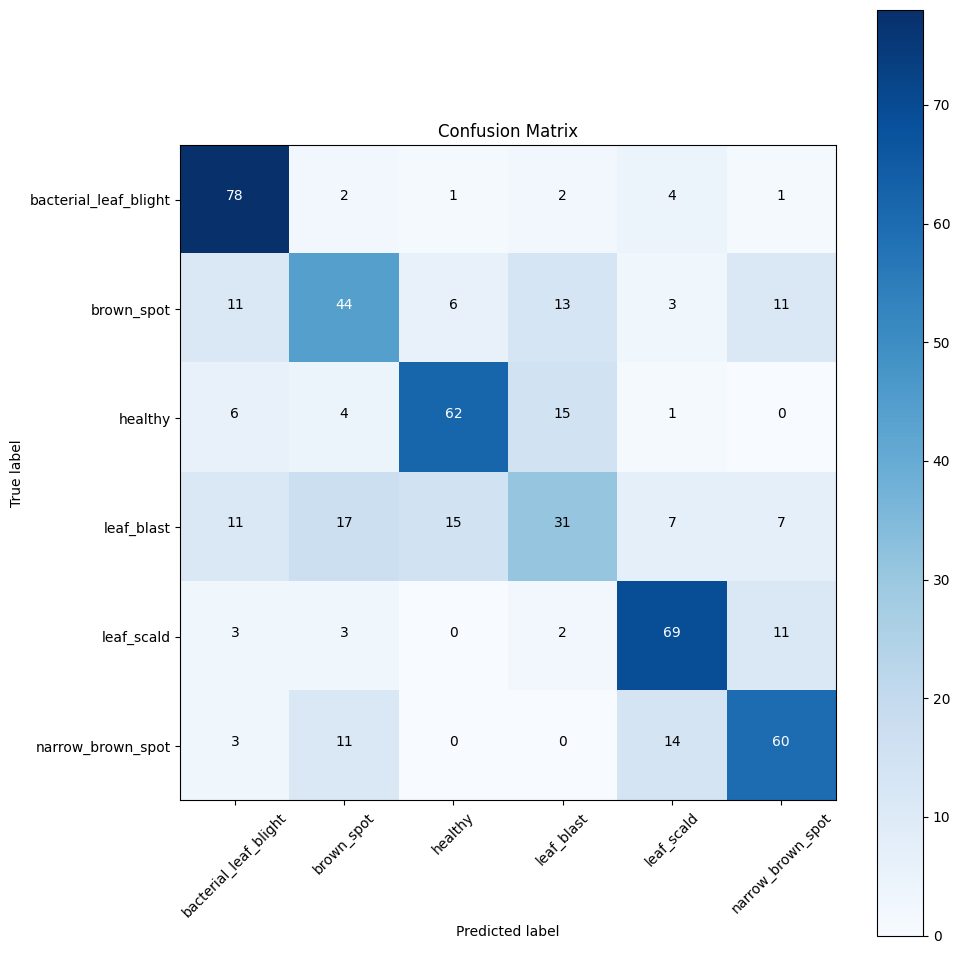

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model_1.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))